# Tweets Dialect Classifier

## 1. Importing libraries and Mounting Google Drive

In [ ]:
pip install --upgrade transformers --no-cache-dir

In [ ]:
pip install numpy==1.26.4

In [ ]:
# mount google drive content to the notebook
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import essential libraries
import os
from datasets import DatasetDict, load_from_disk
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# double check if the transformers library was loaded correctly
print(transformers.__version__)
print(transformers.__file__)
print(transformers.TrainingArguments.__module__)

4.53.2
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py
transformers.training_args


## 2. Loading and Visualizing the Dataset

In [ ]:
# Define the path of the tokenized dataset, can change if needed
TOKENIZED_DATASET_PATH  = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/Data/tweeteraae/processed/tokenized"

# Check the validity of the path
print("Exists:", os.path.exists(TOKENIZED_DATASET_PATH))
print("Is directory:", os.path.isdir(TOKENIZED_DATASET_PATH))
print("Contents:", os.listdir(TOKENIZED_DATASET_PATH))

# List contents of the subfolders to confirm structure
TOKENIZED_TRAIN_PATH = os.path.join(TOKENIZED_DATASET_PATH, "train")
TOKENIZED_EVAL_PATH = os.path.join(TOKENIZED_DATASET_PATH, "validation")
TOKENIZED_TEST_PATH = os.path.join(TOKENIZED_DATASET_PATH, "test")
print("\n-- train contents:", os.listdir(TOKENIZED_TRAIN_PATH))
print("-- validation contents:", os.listdir(TOKENIZED_EVAL_PATH))
print("-- test contents:", os.listdir(TOKENIZED_TEST_PATH))
print()

# Load the dataset
try:
    train_ds = load_from_disk(TOKENIZED_TRAIN_PATH)
    eval_ds = load_from_disk(TOKENIZED_EVAL_PATH)
    test_ds = load_from_disk(TOKENIZED_TEST_PATH)
    dataset = DatasetDict({
        "train": train_ds,
        "validation": eval_ds,
        "test": test_ds
    })
    print("Successfully loaded dataset:", dataset)
    print()
# Throw errors if any exists
except Exception as e:
    print("\nERROR OCCURRED")
    print(type(e), e)

Exists: True
Is directory: True
Contents: ['dataset_dict.json', 'test', 'validation', 'train']

-- train contents: ['data-00000-of-00006.arrow', 'data-00002-of-00006.arrow', 'data-00001-of-00006.arrow', 'data-00004-of-00006.arrow', 'data-00003-of-00006.arrow', 'dataset_info.json', 'state.json', 'data-00005-of-00006.arrow']
-- validation contents: ['dataset_info.json', 'data-00000-of-00001.arrow', 'state.json']
-- test contents: ['data-00000-of-00001.arrow', 'state.json', 'dataset_info.json']



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Successfully loaded dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3433531
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 429191
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 429192
    })
})



In [ ]:
n_samples = 10
for i in range(n_samples):
  sample = train_ds.with_format("python")[i]
  print(sample)

{'text': '"If our love is tragedy why are you my remedy"', 'label': 0, 'input_ids': [0, 61933, 125, 123, 71, 17, 11264, 146, 41, 14, 23, 8123, 56996, 26, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
pip install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=d3b30d1e79a988fe22d1f69e7dbe0624987f30cc5ee533439c7c82dd9708395d
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji


In [ ]:
MODEL_NAME = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
tokens = sample["input_ids"]
decoded_text = tokenizer.decode(tokens, skip_special_tokens=True)

print("Decoded Text:")
print(decoded_text)

print("\nToken IDs:")
print(tokens)

Decoded Text:
"Where are my gloves as wood steering wheels are unkind in cool temperatures."

Token IDs:
[0, 61933, 959, 41, 23, 13158, 52, 2452, 27594, 11489, 41, 439, 653, 16, 501, 30464, 28274, 8472, 639, 26, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# visualize the mapping for some tokens
count = 0
token_strs = tokenizer.convert_ids_to_tokens(tokens)
for tid, tok in zip(tokens, token_strs):
    print(f"{tid:>5} → {tok}")
    count += 1
    if count > 25: # control on how many tokens to print
        print("...")
        break

    0 → <s>
61933 → "@@
  959 → Where
   41 → are
   23 → my
13158 → gloves
   52 → as
 2452 → wood
27594 → steering
11489 → wheels
   41 → are
  439 → un@@
  653 → kind
   16 → in
  501 → cool
30464 → temper@@
28274 → atu@@
 8472 → res@@
  639 → .@@
   26 → "
    2 → </s>
    1 → <pad>
    1 → <pad>
    1 → <pad>
    1 → <pad>
    1 → <pad>
...


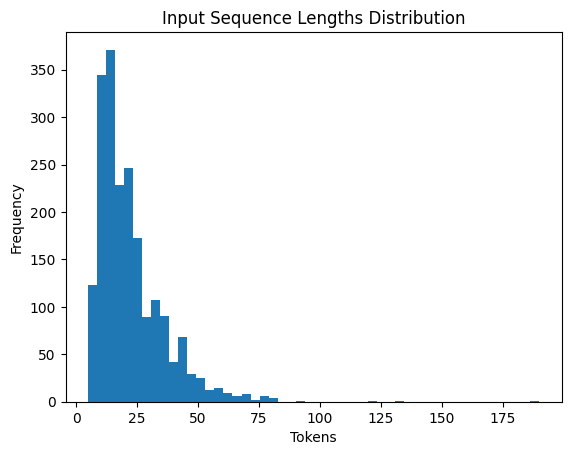

In [ ]:
NO_SAMPLES = 2000 # number of samples to visualize, change if needed
samples = dataset["train"].with_format("python").select(range(NO_SAMPLES))

# Compute tokenized lengths without padding
lengths = [
    len(tokenizer(example["text"], padding=False, truncation=False)["input_ids"])
    for example in samples
]

plt.hist(lengths, bins=50)
plt.title("Input Sequence Lengths Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

## 3. Train and Evaluate the 3-way Classifier

In [ ]:
# ------------------------------------------
# Configs for training, can change if needed
# ------------------------------------------
MODEL_NAME = "vinai/bertweet-base"
LABEL_NAMES = ["White", "AAE-no-AAVE", "AAVE"]
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/models/dialect_classifier"
RESULTS_DIR = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/results/dialect_classifier"
LOGGING_DIR = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/logs"
SEED = 42
# ------------------------------------------

In [ ]:
# define the model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    eval_strategy="steps",
    eval_steps=5000,
    save_steps=5000,
    logging_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    fp16=True,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

In [ ]:
# define the trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/tmp/ipython-input-16-3670262879.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
CHECK_POINT_DIR = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/checkpoints"

# check if the checkpoint directory exists
if os.path.exists(CHECK_POINT_DIR) and os.path.isdir(CHECK_POINT_DIR):
    print(f"Checkpoint found at {CHECK_POINT_DIR}. Resuming training...")
    trainer.train(resume_from_checkpoint=True)
else:
    print("No checkpoint found. Starting training from scratch...")
    trainer.train()

print(f"Training completed! Saving the final model to {MODEL_OUTPUT_DIR}")
trainer.save_model(MODEL_OUTPUT_DIR)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


No checkpoint found. Starting training from scratch...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dsngu97 (dsngu97-boston-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
5000,0.352300,0.349128
10000,0.352700,0.340243
15000,0.350600,0.352116
20000,0.336900,0.334244
25000,0.336500,0.336908
30000,0.335700,0.326659
35000,0.329500,0.329380
40000,0.332600,0.321033
45000,0.332500,0.324732
50000,0.325700,0.324210


Training completed! Saving the final model to /content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/models/dialect_classifier


              precision    recall  f1-score   support

       White       0.80      0.77      0.79    143279
 AAE-no-AAVE       0.82      0.82      0.82    143001
        AAVE       0.95      0.99      0.97    142911

    accuracy                           0.86    429191
   macro avg       0.86      0.86      0.86    429191
weighted avg       0.86      0.86      0.86    429191



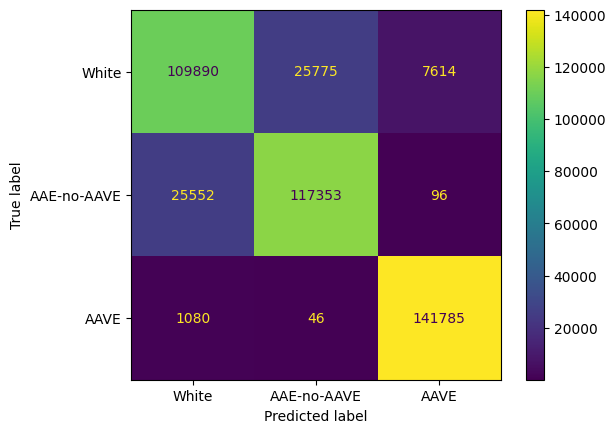

In [ ]:
# visualize the model's performance on the eval set
preds_eval = trainer.predict(eval_ds)
y_pred_eval = torch.argmax(torch.tensor(preds_eval.predictions), dim=1).numpy()
y_true_eval = preds_eval.label_ids

# visualize the metrics
print(classification_report(y_true_eval, y_pred_eval, target_names=LABEL_NAMES))

# visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_true_eval, y_pred_eval, display_labels=LABEL_NAMES)

## 4. Evaluate the 3-way Classifier on the Test Dataset

In [ ]:
# run the model on the test set
preds_final = trainer.predict(test_ds)
y_pred = torch.argmax(torch.tensor(preds_final.predictions), dim=1).numpy()
y_true = preds_final.label_ids

In [ ]:
# extract the results
report = classification_report(y_true, y_pred, target_names=LABEL_NAMES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
White,0.804145,0.766471,0.784856,143374.000000
AAE-no-AAVE,0.819944,0.819887,0.819916,142877.000000
AAVE,0.947150,0.991724,0.968924,142941.000000
accuracy,0.859273,0.859273,0.859273,0.859273
macro avg,0.857080,0.859361,0.857899,429192.000000
weighted avg,0.857032,0.859273,0.857831,429192.000000


In [ ]:
# get the summary metrics
summary_df = pd.DataFrame({
    "Metric": ["accuracy", "f1_macro"],
    "Value": [accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average="macro")]
})
summary_df

,Metric,Value
0,accuracy,0.859273
1,f1_macro,0.857899


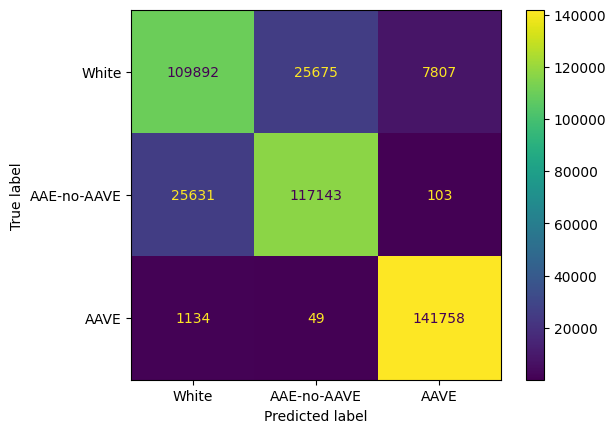

In [ ]:
# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=LABEL_NAMES, columns=LABEL_NAMES)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=LABEL_NAMES)

In [ ]:
os.makedirs(RESULTS_DIR, exist_ok=True)

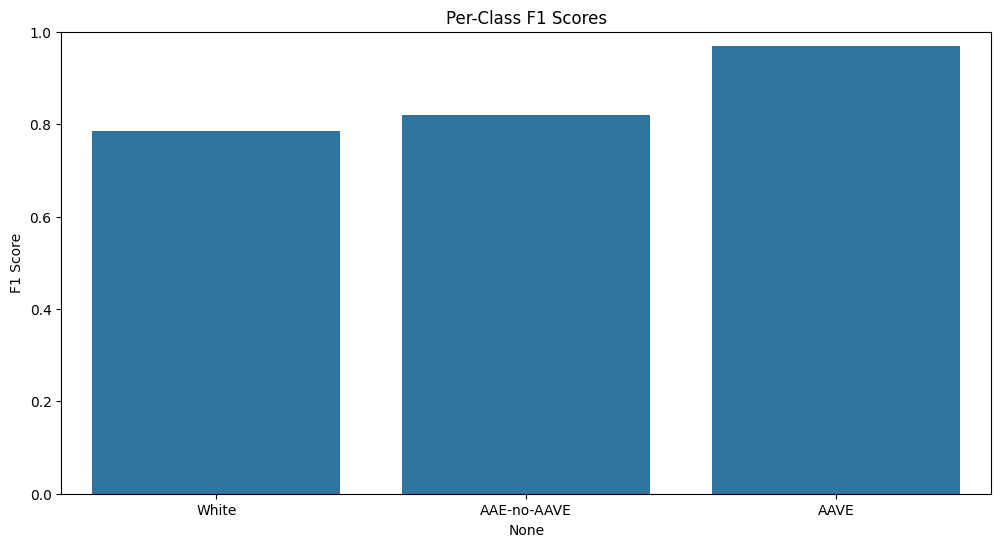

In [ ]:
# Bar plot of F1 per class
f1_per_class = report_df.loc[LABEL_NAMES]["f1-score"]
plt.figure(figsize=(12, 6))
sns.barplot(x=f1_per_class.index, y=f1_per_class.values)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores")
plt.savefig(f"{RESULTS_DIR}/test_f1_scores_by_class.png")
plt.show()

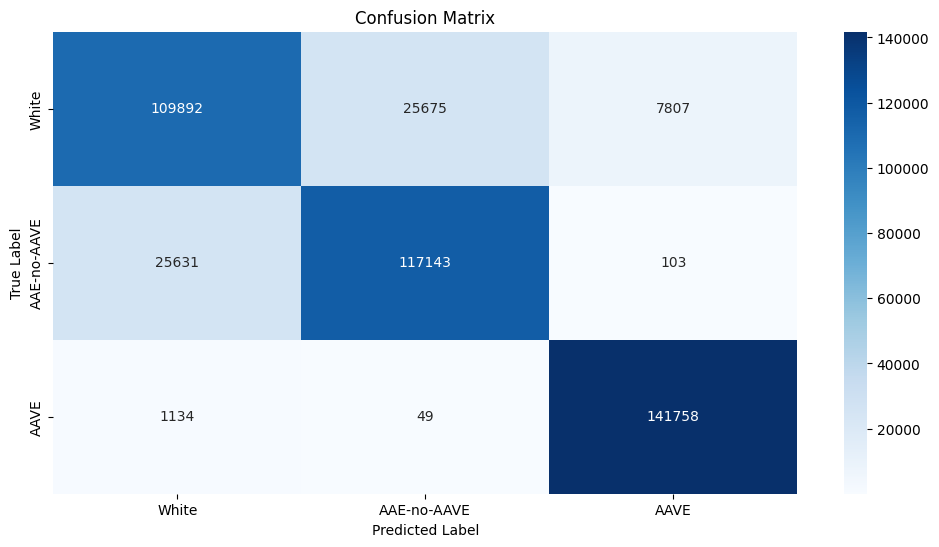

<Figure size 640x480 with 0 Axes>

In [ ]:
# Confusion matrix heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
plt.savefig(f"{RESULTS_DIR}/test_confusion_matrix.png")

In [ ]:
plt.close()

In [ ]:
# save the results to disk
report_df.to_csv(f"{RESULTS_DIR}/test_classification_report.csv")
summary_df.to_csv(f"{RESULTS_DIR}/test_summary_metrics.csv")
cm_df.to_csv(f"{RESULTS_DIR}/test_confusion_matrix.csv")

In [ ]:
# download the results to local machine
import shutil
from google.colab import files

# Create a temp export directory
EXPORT_DIR = "/content/drive/MyDrive/Colab Notebooks/Dialect_Sentiment_Analysis/dialect_export_bundle"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Copy model and results to export dir
shutil.copytree(MODEL_OUTPUT_DIR, os.path.join(EXPORT_DIR, "model"), dirs_exist_ok=True)
shutil.copytree(RESULTS_DIR, os.path.join(EXPORT_DIR, "results/dialect_classifier"), dirs_exist_ok=True)

# Zip the export dir
ZIP_NAME = "dialect_classifier_results"
shutil.make_archive(ZIP_NAME, 'zip', EXPORT_DIR)

# Download the zip file
files.download(ZIP_NAME + ".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>